In [1]:
!pip install pyspark

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark import SparkConf,SparkContext
from pyspark.sql.functions import split, concat_ws
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("dataset15k.csv")

In [7]:
data = data.drop("Summary", axis=1)
data = data.drop("img_m", axis=1)
data = data.drop("img_s", axis=1)
data = data.drop("img_l", axis=1)
data = data.drop("Category", axis=1)
data['isbn'] = pd.to_numeric(data['isbn'], errors='coerce',downcast='integer')
data = data.dropna()
data['isbn'] = data['isbn'].astype(int)
data['user_id'] = data["user_id"].astype(str).str[:4]
data['isbn'] = data["isbn"].astype(str).str[:9]
new_df = data.drop("location", axis=1)

In [8]:
new_df.to_csv("newdataset.csv", index=False)

In [9]:
d = pd.read_csv("newdataset.csv")

In [10]:
d.head()

,Unnamed: 0,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,city,state,country
0,0,2,18.0000,195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,stockton,california,usa
1,1,8,34.7439,2005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,timmins,ontario,canada
2,2,1140,49.0000,2005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,ottawa,ontario,canada
3,4,4138,34.7439,2005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,sudbury,ontario,canada
4,5,6754,30.0000,2005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,toronto,ontario,canada


In [11]:
conf = SparkConf().setAppName("191805056_EsmanurDeli")
sc = SparkContext.getOrCreate(conf=conf)

23/05/23 22:46:00 WARN Utils: Your hostname, Esmanur-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.159.223 instead (on interface en0)
23/05/23 22:46:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/23 22:46:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
dataset = sc.textFile("newdataset.csv")

In [13]:
header = dataset.first()

In [14]:
data = dataset.filter(lambda line: line != header)

In [15]:
num_books = data.count()
print("Number of Books: ", num_books)

Number of Books:  13656


Visualize data

In [16]:
book_fields = data.map(lambda lines: lines.split(","))

In [17]:
book_fields.first()

['0',
 '2',
 '18.0',
 '195153448',
 '0',
 'Classical Mythology',
 'Mark P. O. Morford',
 '2002.0',
 'Oxford University Press',
 'en',
 'stockton',
 'california',
 'usa']

Gerekli yerleri nümerik değere çevirme

In [18]:
isbn = book_fields.map(lambda fields:fields[3])

In [19]:
isbn_filtered = isbn.map(lambda x: int(x) if x.isdigit() else None).filter(lambda x: x is not None)

In [20]:
user_id = book_fields.map(lambda fields:fields[1])

In [21]:
user_id_filtered=user_id.map(lambda x: int(x) if x.isdigit() else None).filter(lambda x: x is not None)

In [22]:
rating = book_fields.map(lambda fields:fields[4])

In [23]:
rating_filtered = rating.map(lambda x: int(x) if x.isdigit() else None).filter(lambda x: x is not None)

In [27]:
user_ages = book_fields.map(lambda x : float(x[2])).collect()

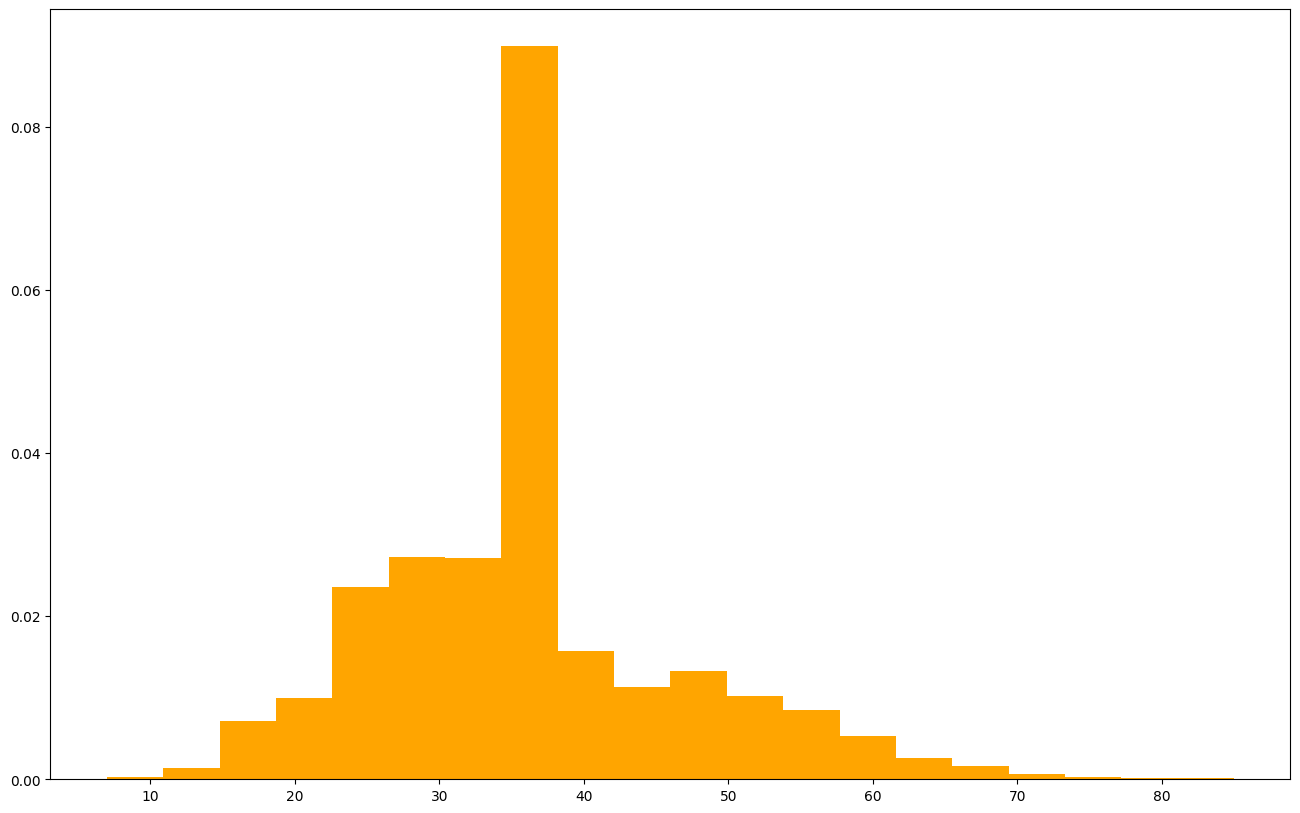

In [34]:
plt.hist(user_ages, bins=20, color="orange", density =True)
fig = plt.gcf()
fig.set_size_inches(16,10)

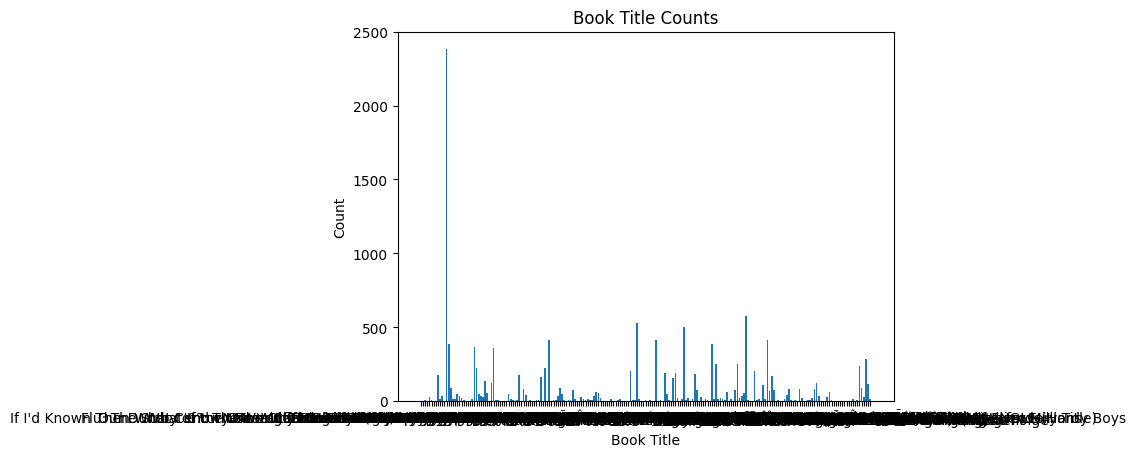

In [42]:
title_counts = book_fields.map(lambda x: (x[5], 1)).reduceByKey(lambda a, b: a + b)

# Book title'ların frekansını çiz
titles = title_counts.collect()
x = [title[0] for title in titles]
y = [title[1] for title in titles]

plt.bar(x, y)
plt.xlabel("Book Title")
plt.ylabel("Count")
plt.title("Book Title Counts")
plt.show()

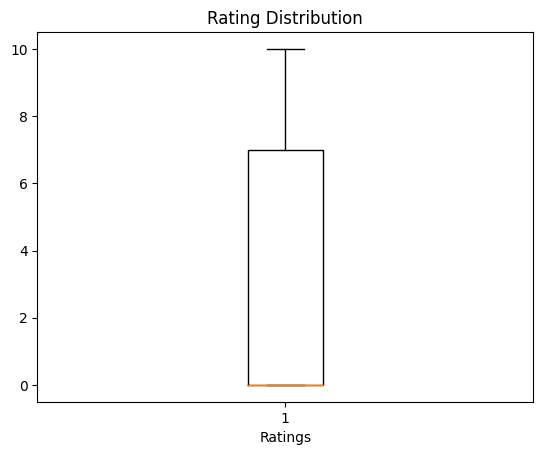

In [47]:
ratings = book_fields.map(lambda x: float(x[4])).collect()

plt.boxplot(ratings)
plt.xlabel("Ratings")
plt.title("Rating Distribution")
plt.show()

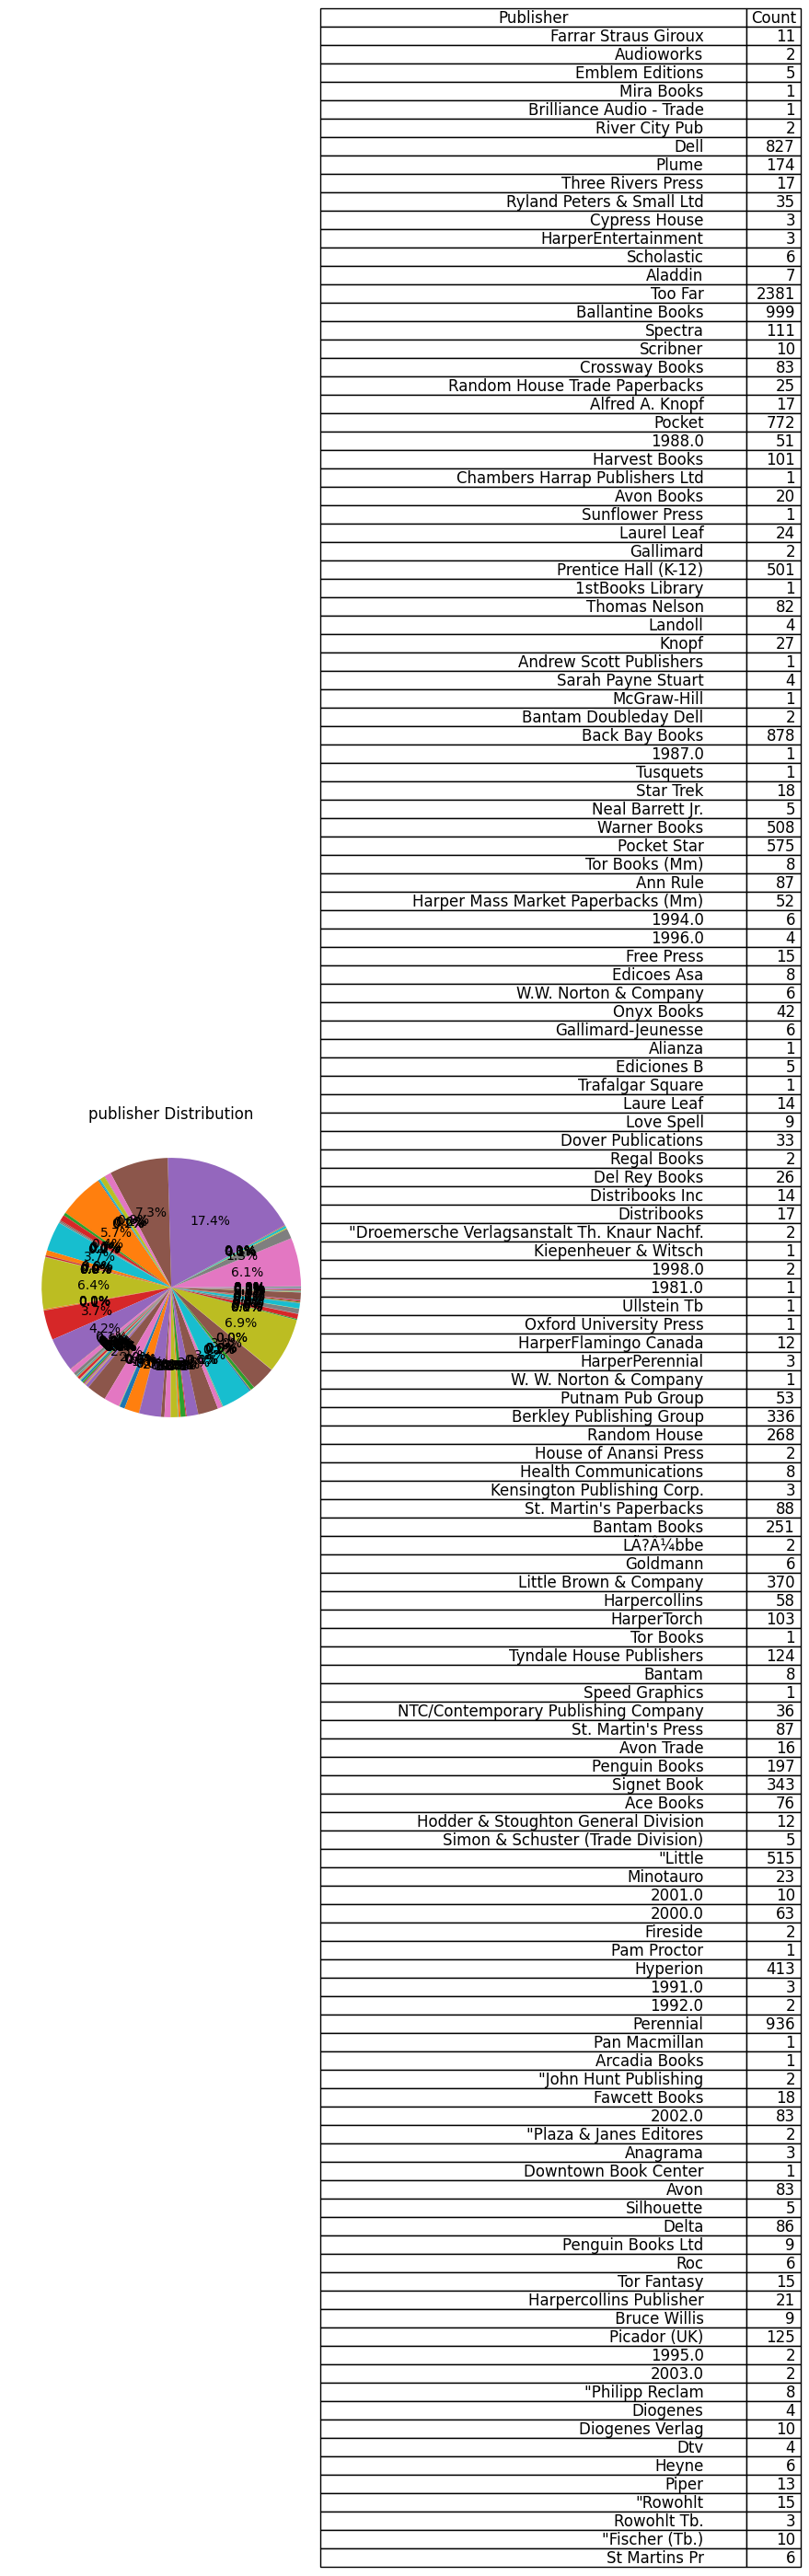

In [59]:
publishers = book_fields.map(lambda x: (x[8], 1)).reduceByKey(lambda a, b: a + b).collect()
x = [pub[0] for pub in publishers]
y = [pub[1] for pub in publishers]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(y, autopct='%1.1f%%')
ax1.set_title('publisher Distribution')

ax2.axis('off')
table_data = [(x, y) for x, y in zip(x, y)]
table = ax2.table(cellText=table_data, colLabels=['Publisher', 'Count'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
table.auto_set_column_width([0, 1])

In [21]:
user_id_filtered.take(3)

[2, 8, 1140]

In [22]:
rating.take(3)

['0', '5', '0']

Reduce kullanımı

In [23]:
book_ratings = data.map(lambda line: line.split(",")).map(lambda x: (x[6], int(x[4])))


In [24]:
average_ratings = book_ratings.reduceByKey(lambda x, y: (x + y) / 2)


In [25]:
for book, rating in average_ratings.collect():
    print(f"Book: {book}, Average Rating: {rating}")


Book: Mark P. O. Morford, Average Rating: 0
Book: Richard Bruce Wright, Average Rating: 6.53369140625
Book: E. J. W. Barber, Average Rating: 0
Book: Amy Tan, Average Rating: 1.6438236982113863
Book: Robert Cowley, Average Rating: 0.5
Book: Scott Turow, Average Rating: 0.0
Book: Sheila Heti, Average Rating: 2.5
Book: R. J. Kaiser, Average Rating: 5
Book: Jack Canfield, Average Rating: 5.421875
Book: Loren D. Estleman, Average Rating: 6
Book: Robert Hendrickson, Average Rating: 1.5
Book: Julia Oliver, Average Rating: 3.5
Book: John Grisham, Average Rating: 1.446900765421845
Book: Toni Morrison, Average Rating: 0.7931664225774198
Book: The Onion, Average Rating: 6.9735260009765625
Book: J. R. Parrish, Average Rating: 2.5
Book: Kathleen Duey, Average Rating: 6
Book: MICHAEL CRICHTON, Average Rating: 1.1030332792556412
Book: Rosamunde Pilcher, Average Rating: 3.0051557342651214
Book: Agatha Christie, Average Rating: 0.051239013671875
Book: Louis L'Amour, Average Rating: 3.42333984375
Book: 

Build recommendation engine using collaborative filtering.

In [26]:
from pyspark.mllib. recommendation import ALS # Alternating Least Squares 
from pyspark.mllib.recommendation import Rating
ratings = book_fields.map (lambda x: Rating(int(x[1]), int(x[3]), float(x[4])))

In [27]:
ratings.take(5)

[Rating(user=2, product=195153448, rating=0.0),
 Rating(user=8, product=2005018, rating=5.0),
 Rating(user=1140, product=2005018, rating=0.0),
 Rating(user=4138, product=2005018, rating=0.0),
 Rating(user=6754, product=2005018, rating=8.0)]

Use %70 of dataset for training, rest of them for testing.

In [62]:
training_data, test_data = ratings.randomSplit([0.7, 0.3])

In [29]:
training_data.take(10)

[Rating(user=8, product=2005018, rating=5.0),
 Rating(user=1140, product=2005018, rating=0.0),
 Rating(user=6754, product=2005018, rating=8.0),
 Rating(user=8552, product=2005018, rating=0.0),
 Rating(user=1236, product=2005018, rating=9.0),
 Rating(user=1774, product=2005018, rating=0.0),
 Rating(user=2002, product=2005018, rating=8.0),
 Rating(user=2109, product=2005018, rating=9.0),
 Rating(user=2190, product=2005018, rating=7.0),
 Rating(user=2633, product=2005018, rating=6.0)]

In [30]:
training_data = training_data.map(lambda x: (x[0], x[1], int(x[2])))

In [31]:
training_data.take(10)

[(8, 2005018, 5),
 (1140, 2005018, 0),
 (6754, 2005018, 8),
 (8552, 2005018, 0),
 (1236, 2005018, 9),
 (1774, 2005018, 0),
 (2002, 2005018, 8),
 (2109, 2005018, 9),
 (2190, 2005018, 7),
 (2633, 2005018, 6)]

Use ALS (Alternating Least Squares) for training recommendation model with last 4 digit
of your student number as a “seed”. Also change the parameters of ALS re-run the
algorithm for parameters “rank” (10, 50, 200), “iteration” (10, 50, 200) and “lambda”
(0.01, 0.1). 

In [32]:
from pyspark.mllib.evaluation import RegressionMetrics

seed = 5056
rank_values = [10, 50, 200]
iteration_values = [10, 50, 200]
lambda_values = [0.01, 0.1]

In [33]:
results = []


In [34]:
model1 = ALS.train(training_data,rank = 10, 
                   iterations = 10, 
                   lambda_ = 0.01,
                   seed = seed)

23/05/23 22:07:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/23 22:07:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/05/23 22:07:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [35]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model1.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': rank_values[0],
    'Iterations': iteration_values[0],
    'Lambda': lambda_values[0],
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 48.51665173291399
RMSE: 6.9653895607434615
-------------------------------


In [36]:
model2 = ALS.train(training_data,rank = 10, 
                   iterations = 50, 
                   lambda_ = 0.01,
                   seed = seed)

In [37]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model2.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 10,
    'Iterations': 50,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 31.86478672307201
RMSE: 5.644890319844311
-------------------------------


model3 = ALS.train(training_data,rank = 10, 
                   iterations = 200, #iterasyondan kaynaklı olabilir
                   lambda_ = 0.01,
                   seed = seed)

test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model3.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 10,
    'Iterations': 200,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(result)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

In [38]:
model4 = ALS.train(training_data,rank = 10, 
                   iterations = 10, 
                   lambda_ = 0.1,
                   seed = seed)

In [39]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model4.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 10,
    'Iterations': 10,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 24.39932623463042
RMSE: 4.939567413714527
-------------------------------


In [40]:
model5 = ALS.train(training_data,rank = 10, 
                   iterations = 50, 
                   lambda_ = 0.1,
                   seed = seed)

In [41]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model5.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 10,
    'Iterations': 50,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 22.620275554460505
RMSE: 4.756077748992388
-------------------------------


model6 = ALS.train(training_data,rank = 10, 
                   iterations = 200, #200 olunca sorun çıkarıyor
                   lambda_ = 0.1,
                   seed = seed)

test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model6.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 10,
    'Iterations': 200,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(result)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

In [42]:
model7 = ALS.train(training_data,rank = 50, 
                   iterations = 10, 
                   lambda_ = 0.01,
                   seed = seed)

In [43]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model7.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 50,
    'Iterations': 10,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 20.66640683310885
RMSE: 4.546031987690897
-------------------------------


In [44]:
model8 = ALS.train(training_data,rank = 50, 
                   iterations = 50, 
                   lambda_ = 0.01,
                   seed = seed)

In [45]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model8.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 50,
    'Iterations': 50,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 19.279690069273517
RMSE: 4.390864387483804
-------------------------------


model9 = ALS.train(training_data,rank = 50, 
                   iterations = 200, 
                   lambda_ = 0.01,
                   seed = seed)

test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model9.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 50,
    'Iterations': 200,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(result)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

In [46]:
model10 = ALS.train(training_data,rank = 50, 
                   iterations = 10, 
                   lambda_ = 0.1,
                   seed = seed)

In [47]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model10.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 50,
    'Iterations': 10,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 20.037665653231183
RMSE: 4.476345122220938
-------------------------------


In [48]:
model11 = ALS.train(training_data,rank = 50, 
                   iterations = 50, 
                   lambda_ = 0.1,
                   seed = seed)

In [49]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model11.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 50,
    'Iterations': 50,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 19.71921113390271
RMSE: 4.440631839491168
-------------------------------


model12 = ALS.train(training_data,rank = 50, 
                   iterations = 200, 
                   lambda_ = 0.01,
                   seed = seed)

test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model12.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 50,
    'Iterations': 200,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(result)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

In [50]:
model13 = ALS.train(training_data,rank = 200, 
                   iterations = 10, 
                   lambda_ = 0.01,
                   seed = seed)

In [51]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model13.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 200,
    'Iterations': 10,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 19.15292743660493
RMSE: 4.376405766905639
-------------------------------


In [52]:
model14 = ALS.train(training_data,rank = 200, 
                   iterations = 50, 
                   lambda_ = 0.01,
                   seed = seed)

In [53]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model14.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 200,
    'Iterations': 50,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 19.08581033994024
RMSE: 4.368730975917405
-------------------------------


model15 = ALS.train(training_data,rank = 200, 
                   iterations = 200, 
                   lambda_ = 0.01,
                   seed = seed)

test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model15.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 200,
    'Iterations': 200,
    'Lambda': 0.01,
    'MSE': mse,
    'RMSE': rmse
}
results.append(result)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

In [54]:
model16 = ALS.train(training_data,rank = 200, 
                   iterations = 10, 
                   lambda_ = 0.1,
                   seed = seed)

In [55]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model16.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 200,
    'Iterations': 10,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 19.82040073175705
RMSE: 4.4520108638408615
-------------------------------


In [56]:
model17 = ALS.train(training_data,rank = 200, 
                   iterations = 50, 
                   lambda_ = 0.1,
                   seed = seed)

In [57]:
test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model17.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 200,
    'Iterations': 50,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(rmse)
print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

Model Parameters: Rank=0.01, Iterations=10, Lambda=0.01
MSE: 19.745909226641604
RMSE: 4.443636936861697
-------------------------------


model18 = ALS.train(training_data,rank = 200, 
                   iterations = 200, 
                   lambda_ = 0.1,
                   seed = seed)

test_user_product = test_data.map(lambda x: (x[0], x[1]))
predictions = model18.predictAll(test_user_product).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test_data.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
mse = rates_and_preds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
rmse = mse**0.5

result = {
    'Rank': 200,
    'Iterations': 200,
    'Lambda': 0.1,
    'MSE': mse,
    'RMSE': rmse
}
results.append(result)

print("Model Parameters: Rank={}, Iterations={}, Lambda={}".format(lambda_values[0], iteration_values[0], lambda_values[0]))
print("MSE:", mse)
print("RMSE:", rmse)
print("-------------------------------")

ALS ile tahminde bulunup (predict) bunu yan yana gelecek şekilde orijinal (gerçek değerler ile) değerlendirmeler ile karşılaştırması olmalı. En iyi model ile bunu yapıyoruz

In [59]:
# Test verilerini alın
test_data = test_data.collect()

# Her bir test verisi için tahmin yapın ve gerçek değerlerle karşılaştırın
for row in test_data:
    user_id = row.user
    item_id = row.product
    rating = row.rating
    
    if model1.userFeatures().lookup(user_id) and model1.productFeatures().lookup(item_id):
        # Tahmin yap
        predicted_rating = model1.predict(user_id, item_id)
        
        # Gerçek değer ile karşılaştır
        print("Gerçek Değer: {}, Tahmin: {}".format(rating, predicted_rating))

Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: -1.70380413143789
Gerçek Değer: 7.0, Tahmin: -2.662121919881783
Gerçek Değer: 9.0, Tahmin: -18.760856919471323
Gerçek Değer: 6.0, Tahmin: 1.0597290144894966
Gerçek Değer: 0.0, Tahmin: 4.701921490791699
Gerçek Değer: 7.0, Tahmin: -13.962514472877071
Gerçek Değer: 0.0, Tahmin: 20.174244330087454
Gerçek Değer: 8.0, Tahmin: 4.8545945618074455
Gerçek Değer: 8.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 1.40250475446501
Gerçek Değer: 0.0, Tahmin: 0.47642043590007876
Gerçek Değer: 0.0, Tahmin: -9.053366370781319
Gerçek Değer: 10.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: -2.407271221880613
Gerçek Değer: 0.0, Tahmin: 0.0
Gerçek Değer: 0.0, Tahmin: 0.1318574665252642
Gerçek Değer: 0.0, Tahmin: -0.9452664081698945
Gerçek Değer: 8.0, Tahmin: 0.0
Gerçek Değer: 10.0, Tahmin: 7.5302996466142735
Gerçek Değer: 0.0, Tahmin: 0.15819930448341202
Gerçek Değer: 0.0, Tahmin: 7.6483250578349065
Gerçek Değer: 0.0, Tahmin: 0.5094410249168808
Gerçek Değer: 

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


Gerçek Değer: 0.0, Tahmin: -3.5067110290371595


KeyboardInterrupt: 

In [60]:
def cosinesimilarity(item_id, a, b):
    dot = np.dot (a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return cos

In [63]:
import numpy as np
test_data = test_data.collect()
unique_item_ids = set()

for row in test_data:
    item_id = row.product
    rating = row.rating
    
    if item_id not in unique_item_ids:  # Eğer item_id daha önce işlenmediyse
        unique_item_ids.add(item_id)
    
        if model1.productFeatures().lookup(item_id):
            # Tahmin yap
            item_vector = model1.productFeatures ().lookup(item_id)[0]
            cos = cosinesimilarity(item_id, item_vector, item_vector)

            # Gerçek değer ile karşılaştır
            print("İtem: {}, cosine similarity: {}".format(item_id, cos))

İtem: 2005018, cosine similarity: 1.0
İtem: 60973129, cosine similarity: 1.0000000000000002
İtem: 374157065, cosine similarity: 0.9999999999999998
İtem: 399135782, cosine similarity: 1.0000000000000002


/var/folders/4p/4qnh8s0n31s8tylgw5vp1r1r0000gn/T/ipykernel_32759/2317248424.py:5: RuntimeWarning: invalid value encountered in double_scalars
  cos = dot / (norma * normb)


İtem: 425176428, cosine similarity: nan
İtem: 671870432, cosine similarity: nan
İtem: 771074670, cosine similarity: 0.9999999999999999
İtem: 887841740, cosine similarity: 0.9999999999999998
İtem: 155874621, cosine similarity: 0.9999999999999998
İtem: 156740778, cosine similarity: 0.9999999999999999
İtem: 157566393, cosine similarity: 1.0
İtem: 440234743, cosine similarity: 1.0000000000000002
İtem: 452264464, cosine similarity: 0.9999999999999999
İtem: 609804618, cosine similarity: 1.0000000000000002
İtem: 184172152, cosine similarity: 1.0
İtem: 187938449, cosine similarity: 0.9999999999999999
İtem: 439095026, cosine similarity: 0.9999999999999999
İtem: 971880107, cosine similarity: 0.9999999999999999
İtem: 345402871, cosine similarity: 0.9999999999999999
İtem: 345417623, cosine similarity: 1.0
İtem: 312978383, cosine similarity: 0.9999999999999998
İtem: 425099148, cosine similarity: 1.0
İtem: 553264990, cosine similarity: 1.0000000000000002
İtem: 553278398, cosine similarity: 0.9999999

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


İtem: 505524996, cosine similarity: nan


KeyboardInterrupt: 

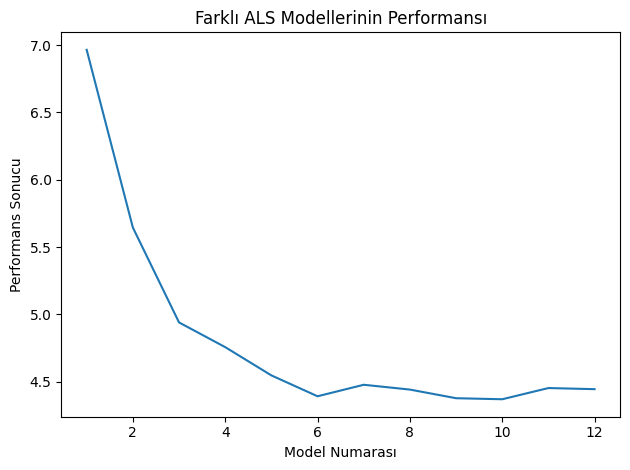

In [66]:
import matplotlib.pyplot as plt

# Grafik için x ve y değerlerini ayır
x = range(1,13)  # Modellerin numaraları
y = results  # Performans sonuçları

# Grafik oluşturma
plt.plot(x, y)
plt.xlabel('Model Numarası')
plt.ylabel('Performans Sonucu')
plt.title('Farklı ALS Modellerinin Performansı')
plt.show()
